# This notebook builds a general stock market RNN then finetunes it for a particular basket of stocks

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from scipy import signal
import pickle

In [3]:
import pandas as pd

## I run Tensorflow in Nvidia-Docker, which doesn't come with pandas_datareader installed 

In [5]:
#!pip install pandas_datareader

In [6]:
from pandas_datareader import data

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (22, 9)

In [8]:
basket = ['EAT', 'TWTR', 'TTNP', 'SBUX', 'BAC', 'SHLDQ', 'STM', 'ACB', 'GREK']

In [9]:
df = data.DataReader(basket, 'robinhood')

In [10]:
# TODO: Should duplicate items in the basket in different orders to expand the training set

In [10]:
df.head()

close_price high_price  interpolated  low_price open_price  \
symbol begins_at                                                               
EAT    2017-12-06   36.303300  38.114100         False  36.043200  37.603600   
       2017-12-07   35.894600  36.740200         False  35.836300  35.894600   
       2017-12-08   36.390900  37.130400         False  35.651400  35.962800   
       2017-12-11   37.334700  37.519600         False  36.429800  36.566000   
       2017-12-12   37.334700  37.762800         False  37.062300  37.558500   

                  session   volume  
symbol begins_at                    
EAT    2017-12-06     reg  1713866  
       2017-12-07     reg  1448719  
       2017-12-08     reg  1338245  
       2017-12-11     reg  1482376  
       2017-12-12     reg   870873

In [11]:
#df = orig.copy()

In [12]:
orig = df.copy()

In [13]:
df=df.reset_index()

In [14]:
df.head()

,symbol,begins_at,close_price,high_price,interpolated,low_price,open_price,session,volume
0,EAT,2017-12-06,36.303300,38.114100,False,36.043200,37.603600,reg,1713866
1,EAT,2017-12-07,35.894600,36.740200,False,35.836300,35.894600,reg,1448719
2,EAT,2017-12-08,36.390900,37.130400,False,35.651400,35.962800,reg,1338245
3,EAT,2017-12-11,37.334700,37.519600,False,36.429800,36.566000,reg,1482376
4,EAT,2017-12-12,37.334700,37.762800,False,37.062300,37.558500,reg,870873


# Feature engineering

De-trend and add a few extra features

In [15]:
X_scalers = {}
y_scalers = {}
for stock in basket:
    for col in ('close_price', 'high_price', 'low_price', 'open_price', 'volume'):
        df[col] = df[col].astype(float)
        df.loc[df['symbol'] == stock, col] = signal.detrend(df[df['symbol'] == stock][col])
    df.loc[df['symbol'] == stock, 'mean_close_price_2'] = df.loc[df['symbol'] == stock, 'close_price'].rolling(window=2).mean()
    df.loc[df['symbol'] == stock, 'mean_close_price_3'] = df.loc[df['symbol'] == stock, 'close_price'].rolling(window=3).mean()
    df.loc[df['symbol'] == stock, 'std_close_price_2'] = df.loc[df['symbol'] == stock, 'close_price'].rolling(window=2).std()
    df.loc[df['symbol'] == stock, 'std_close_price_3'] = df.loc[df['symbol'] == stock, 'close_price'].rolling(window=3).std()

In [16]:
X_scalers = {stock:{} for stock in basket}
y_scalers = {}

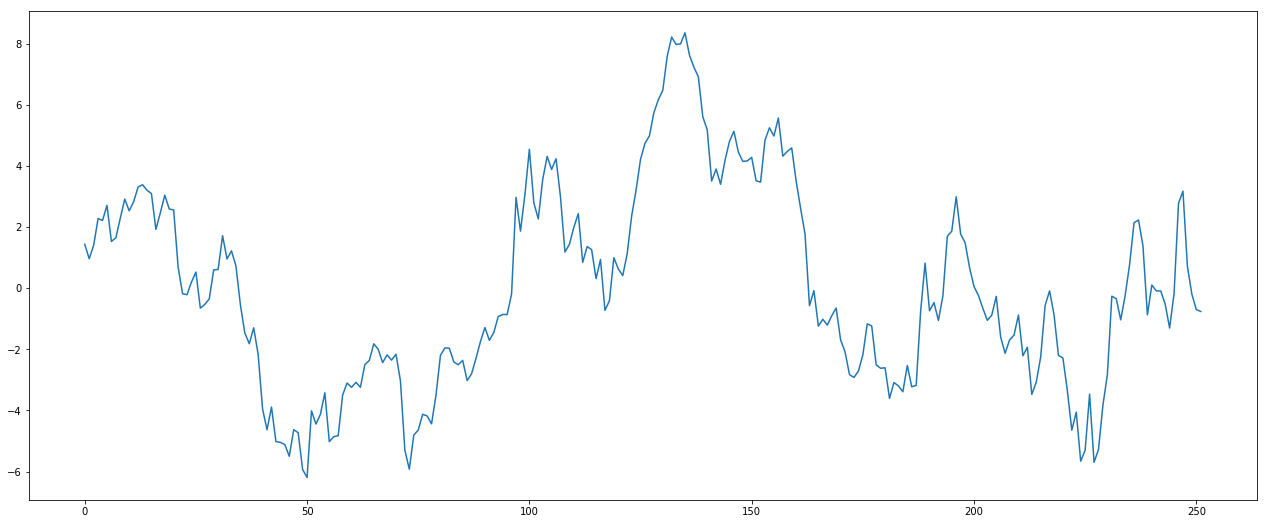

In [17]:
plt.plot(df[df['symbol'] == 'EAT']['close_price'])

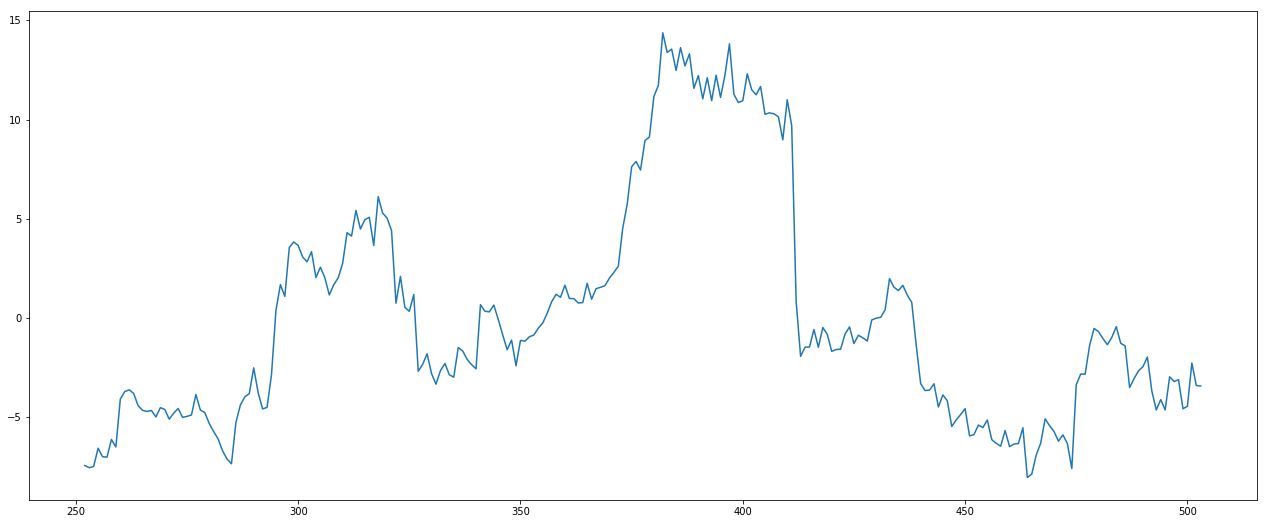

In [18]:
plt.plot(df[df['symbol'] == 'TWTR']['close_price'])

In [19]:
df['tomo_gain'] = df['close_price'].shift(-1) - df['close_price']
df['yday_gain'] = df['tomo_gain'].shift(1)

# This is not ok - note the last one

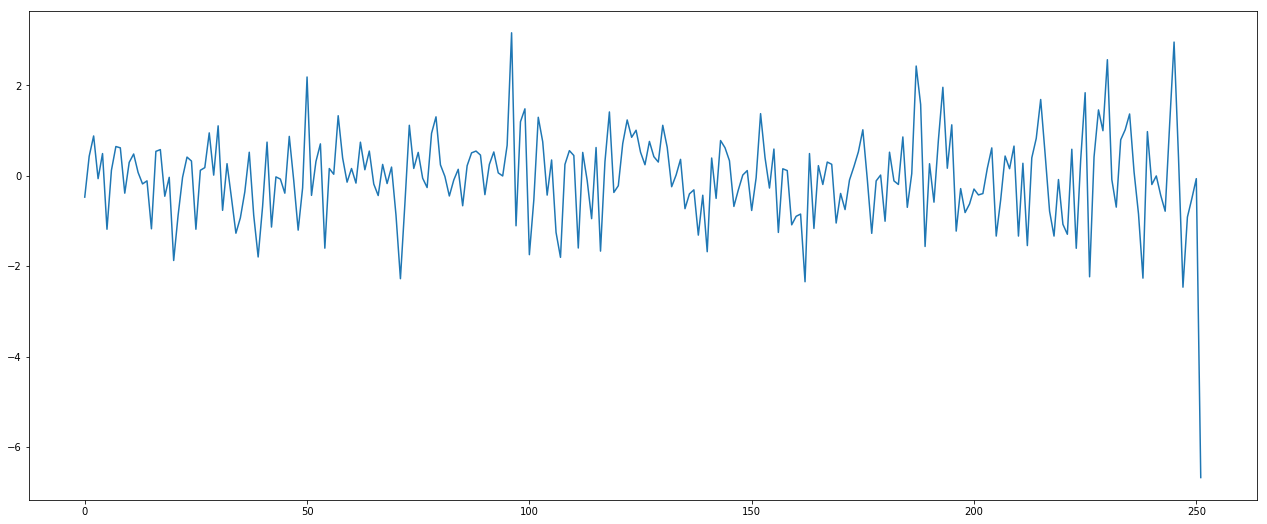

In [20]:
plt.plot(df[df['symbol'] == 'EAT']['tomo_gain'])

# This is better

In the for loop below, the last row of each stock symbol is dropped.

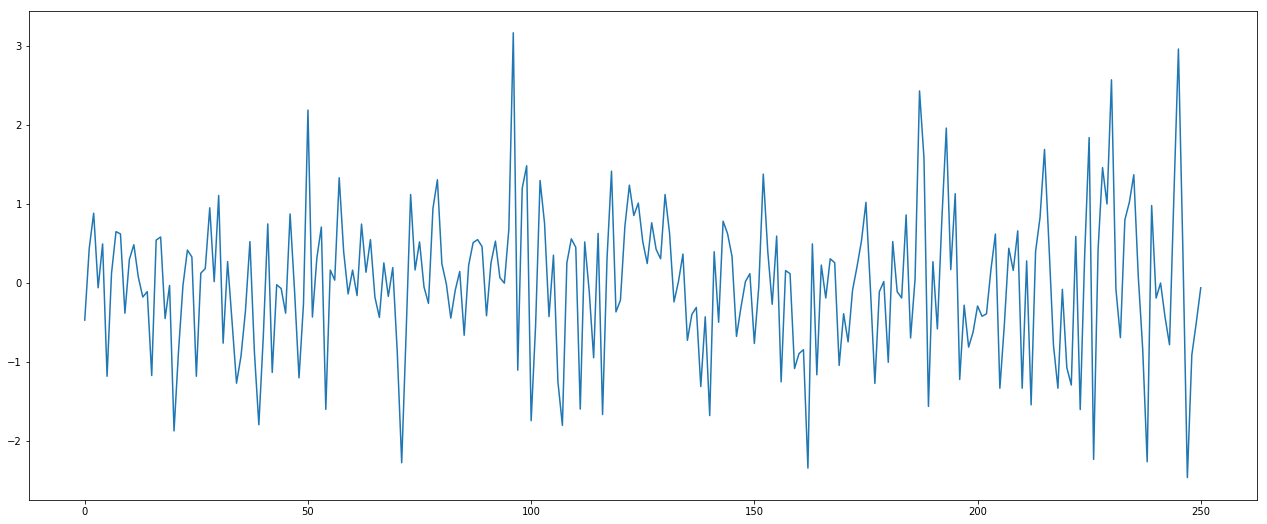

In [21]:
plt.plot(df[df['symbol'] == 'EAT'][:-1]['tomo_gain'])

# Create datetime features

In [22]:
as_date = df['begins_at'].dt
df['dayofweek'] = as_date.dayofweek
df['quarter'] = as_date.quarter
df['weekofyear'] = as_date.weekofyear

In [23]:
df = df.drop(['begins_at', 'interpolated', 'session'], axis=1)
df = df.dropna(axis=0) # Due to window, first two rows now contain nans
df = df.reset_index(drop=True)

In [24]:
df.head()

,symbol,close_price,high_price,low_price,open_price,volume,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain,dayofweek,quarter,weekofyear
0,EAT,1.405339,1.583064,1.058660,0.926952,-270477.337749,1.188437,1.273202,0.306746,0.261919,0.881304,0.433804,4,4,49
1,EAT,2.286643,1.908639,1.776767,1.468203,-124089.801373,1.845991,1.554506,0.623176,0.670123,-0.062496,0.881304,0,4,50
2,EAT,2.224147,2.088214,2.348973,2.398754,-733336.264996,2.255395,1.972043,0.044191,0.491774,0.492104,-0.062496,1,4,50
3,EAT,2.716251,2.559789,2.531879,2.239506,-573758.728619,2.470199,2.409014,0.347970,0.267904,-1.181396,0.492104,2,4,50
4,EAT,1.534855,2.296664,1.868386,2.644657,-455149.192243,2.125553,2.158418,0.835373,0.593434,0.122304,-1.181396,3,4,50


In [25]:
for stock in basket:
    df = df.drop(df.index[len(df[df['symbol'] == stock]) - 1], axis=0)
    outliers = abs(df[df['symbol'] == stock]['tomo_gain']) < df[df['symbol'] == stock]['tomo_gain'].std() * 3
    df[df['symbol'] == stock] = df[df['symbol'] == stock].loc[:, :][outliers]
    df = df.drop(df[df['symbol'] == stock].iloc[-1].name) # get rid of last because next is a different stock
    pre_y = df[df['symbol'] == stock]['tomo_gain'].values
    y_scalers[stock] = make_pipeline(StandardScaler(), MinMaxScaler(feature_range=(-1, 1)))
    for col in ('close_price', 'high_price', 'low_price', 'open_price', 'volume', 'mean_close_price_2', \
               'mean_close_price_3', 'std_close_price_2', 'std_close_price_3', 'yday_gain'):
        pre_x = df[df['symbol'] == stock][col]
        X_scalers[stock][col] = make_pipeline(StandardScaler(), MinMaxScaler(feature_range=(-1, 1)))
        df.loc[df['symbol'] == stock, col] = X_scalers[stock][col].fit_transform(pre_x.values.reshape(-1,1))
    df.loc[df['symbol'] == stock, 'tomo_gain'] = y_scalers[stock].fit_transform(pre_y.reshape(-1, 1)).reshape(-1)

# Save the feature scalers

In [26]:
pickle.dump(X_scalers, open('x_scalers.pkl', 'wb'))
pickle.dump(y_scalers, open('y_scalers.pkl', 'wb'))

# Note same shape but now different scale

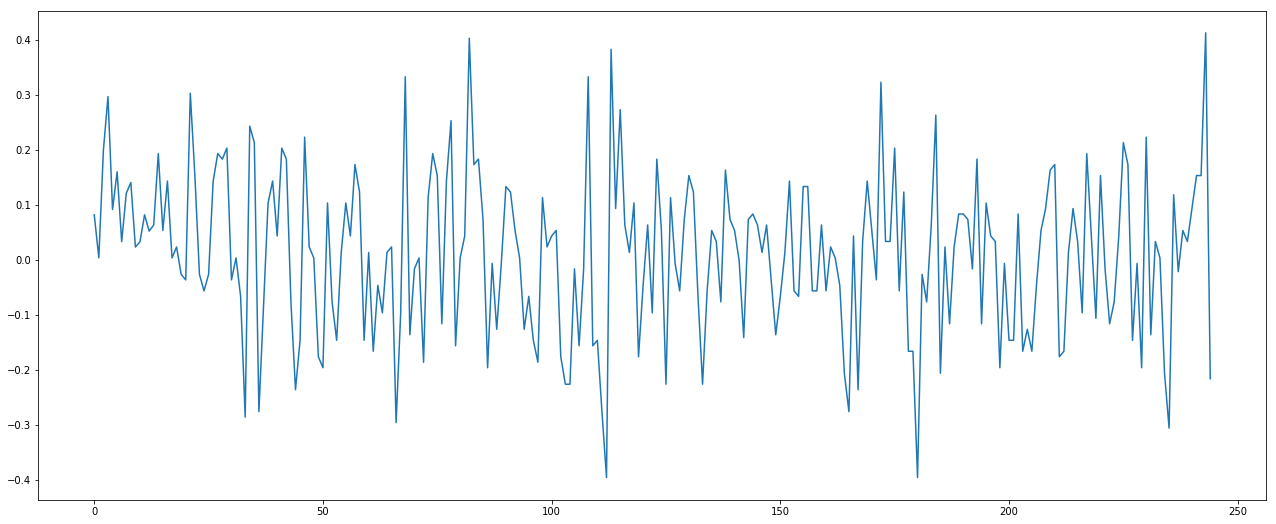

In [27]:
plt.plot(pre_y)

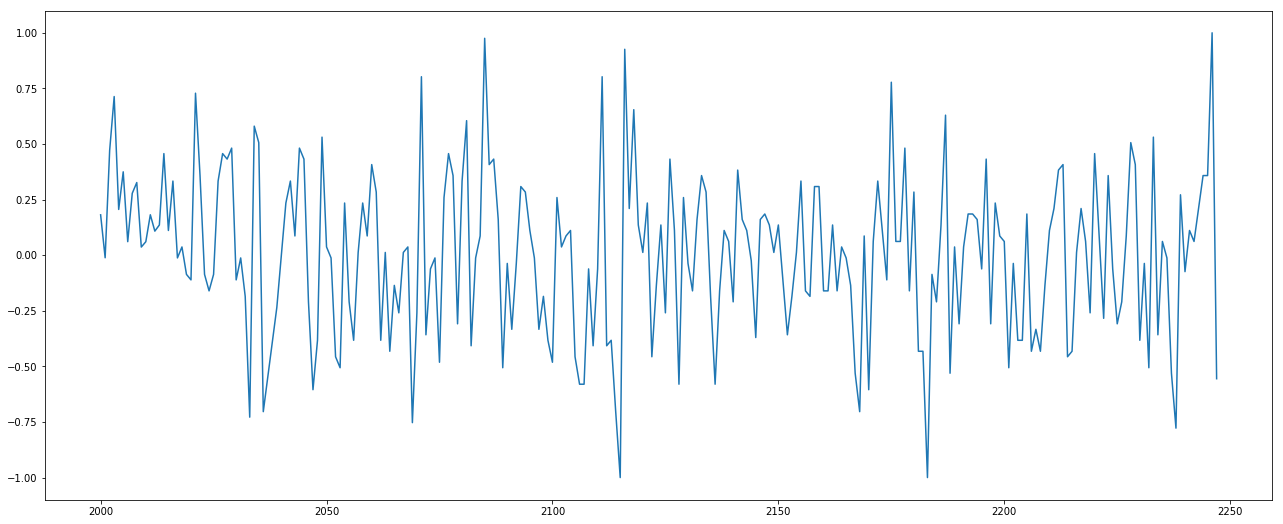

In [28]:
plt.plot( df.loc[df['symbol'] == basket[-1], 'tomo_gain'])

In [29]:
df = df.dropna(axis=0)

In [30]:
df.head()

,symbol,close_price,high_price,low_price,open_price,volume,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain,dayofweek,quarter,weekofyear
0,EAT,0.043785,0.000621,0.065120,-0.035294,-0.652279,0.017717,0.003163,-0.727021,-0.782744,0.329543,0.029796,4.0,4.0,49.0
1,EAT,0.164788,0.040904,0.155453,0.030891,-0.583165,0.109997,0.044109,-0.443794,-0.388911,-0.045726,0.188907,0.0,4.0,50.0
2,EAT,0.156207,0.063122,0.227433,0.144679,-0.870806,0.167452,0.104884,-0.962025,-0.560981,0.174791,-0.146667,1.0,4.0,50.0
3,EAT,0.223773,0.121469,0.250442,0.125206,-0.795465,0.197597,0.168489,-0.690122,-0.776970,-0.490616,0.050524,2.0,4.0,50.0
4,EAT,0.061567,0.088913,0.166978,0.174748,-0.739467,0.149230,0.132012,-0.253863,-0.462900,0.027753,-0.544498,3.0,4.0,50.0


In [31]:
df[df['symbol'] == 'EAT'].describe()

,close_price,high_price,low_price,open_price,volume,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain,dayofweek,quarter,weekofyear
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,-0.149507,-0.196242,-0.069079,-0.149082,-0.522479,-0.148566,-0.181362,-0.558367,-0.414368,-0.034162,-0.128733,2.036585,2.487805,26.296748
std,0.450919,0.402970,0.412819,0.406875,0.276920,0.456281,0.469261,0.377187,0.400775,0.350537,0.327306,1.409401,1.109262,14.787659
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,1.000000
25%,-0.482336,-0.510443,-0.384262,-0.453198,-0.716048,-0.493541,-0.546237,-0.841594,-0.706446,-0.233201,-0.314311,1.000000,2.000000,14.000000
50%,-0.209288,-0.246213,-0.111835,-0.200166,-0.578356,-0.198139,-0.218810,-0.669331,-0.485782,-0.010616,-0.109991,2.000000,2.000000,26.000000
75%,0.189439,0.099710,0.214158,0.148749,-0.383546,0.190122,0.143363,-0.364143,-0.223881,0.186730,0.061200,3.000000,3.000000,39.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,52.000000


In [32]:
df.shape

(2207, 15)

In [33]:
num_df_cols = df.shape[1] - 1 + len(basket) - 1

In [34]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(num_df_cols, input_shape=(1, num_df_cols)))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1)) # dont squash output gradient

In [35]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [36]:
X = df.drop(['tomo_gain', 'symbol'], axis=1)
y = df['tomo_gain']

In [37]:
dummies = pd.get_dummies(df['symbol'], columns=['symbol'])

In [38]:
X = np.append(X, dummies.values, axis=1)

In [39]:
X.shape

(2207, 22)

In [40]:
# Reshape to num_samples, timesteps, num_features
X = np.reshape(X, (-1, 1, num_df_cols))

## Sanity check

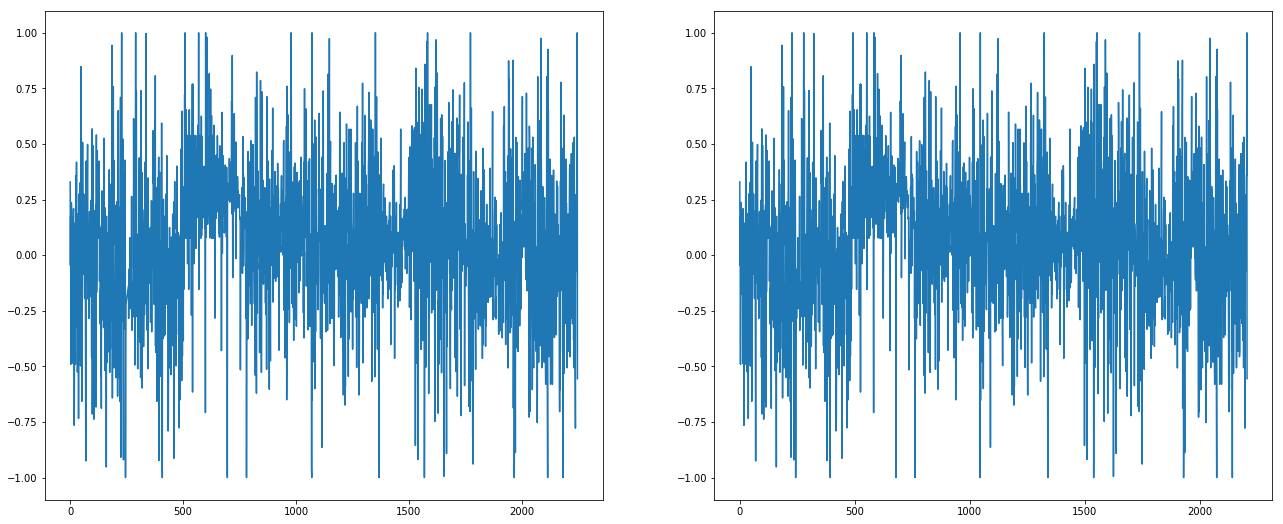

In [41]:
plt.subplot(1,2,1)
plt.plot(y)
plt.subplot(1,2,2)
plt.plot(df['tomo_gain'].values)

# Fit the base model

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
model.fit(X_train, y_train.values.reshape(-1,1), batch_size=64, epochs=1000, verbose=0)
model.fit(X_train, y_train.values.reshape(-1,1), batch_size=32, epochs=6)

Epoch 1/6
1765/1765 [==============================] - 0s 193us/step - loss: 0.0290 - mean_squared_error: 0.0290
Epoch 2/6
1765/1765 [==============================] - 0s 197us/step - loss: 0.0308 - mean_squared_error: 0.0308
Epoch 3/6
1765/1765 [==============================] - 0s 192us/step - loss: 0.0307 - mean_squared_error: 0.0307
Epoch 4/6
1765/1765 [==============================] - 0s 195us/step - loss: 0.0287 - mean_squared_error: 0.0287
Epoch 5/6
1765/1765 [==============================] - 0s 188us/step - loss: 0.0278 - mean_squared_error: 0.0278
Epoch 6/6
1765/1765 [==============================] - 0s 190us/step - loss: 0.0292 - mean_squared_error: 0.0292


In [45]:
model.evaluate(X_test, y_test)

442/442 [==============================] - 0s 457us/step


[0.14910495732974144, 0.14910495732974144]

# Sanity checks

In [46]:
model.reset_states()

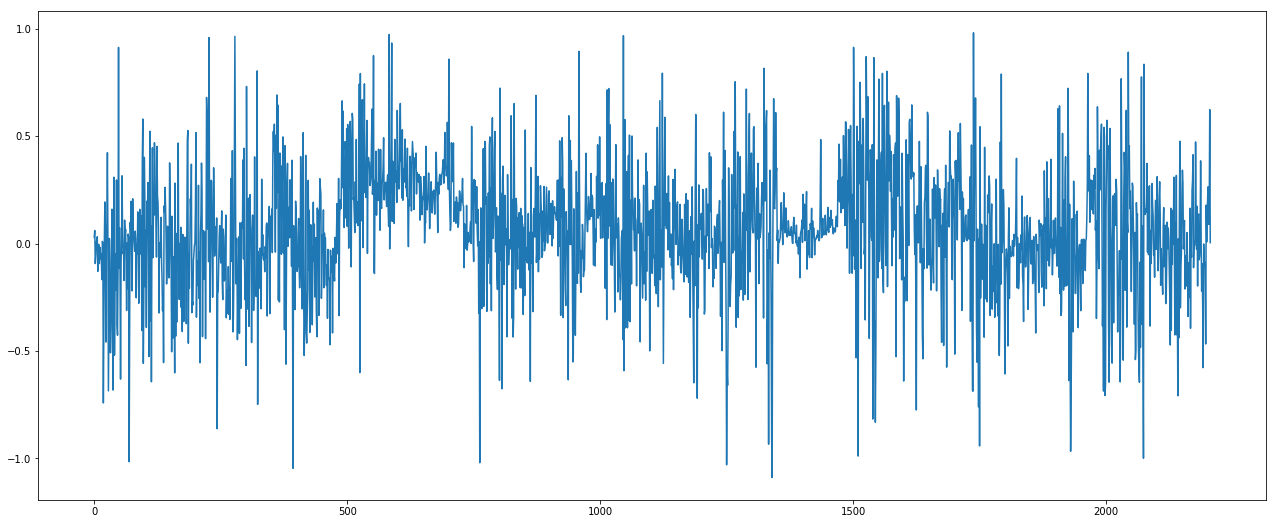

In [47]:
plt.plot(model.predict(X))

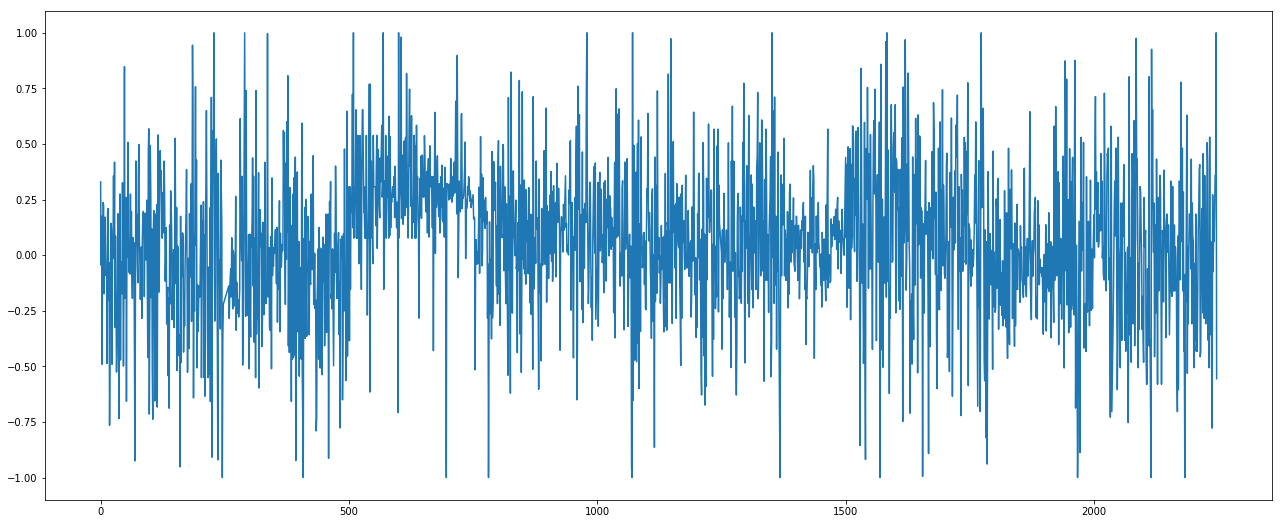

In [48]:
plt.plot(y)

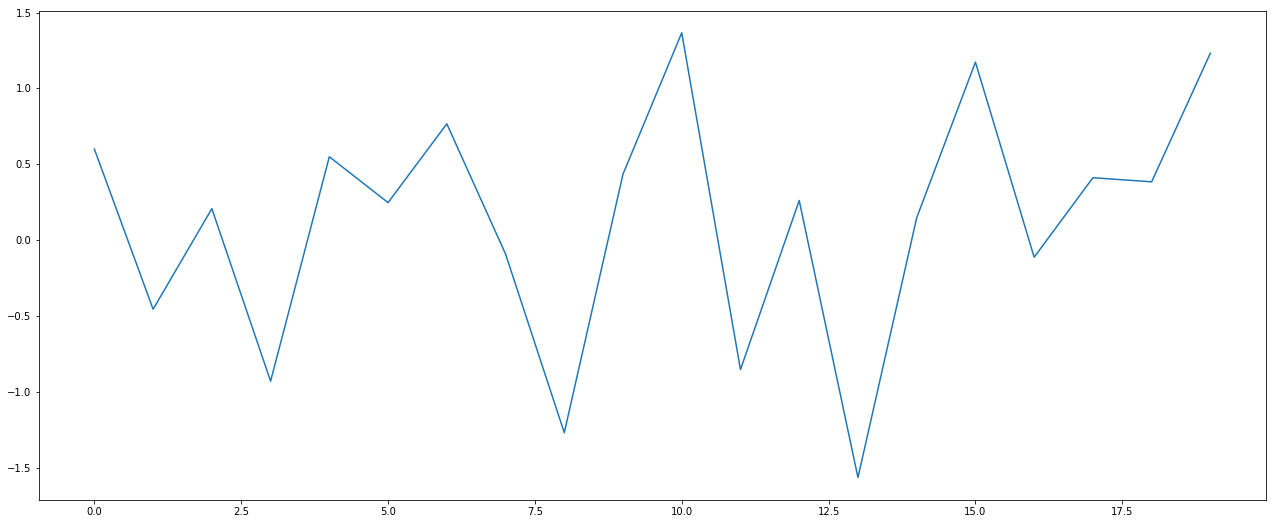

In [49]:
plt.plot(y_scalers['EAT'].inverse_transform(model.predict(X[100:120])))

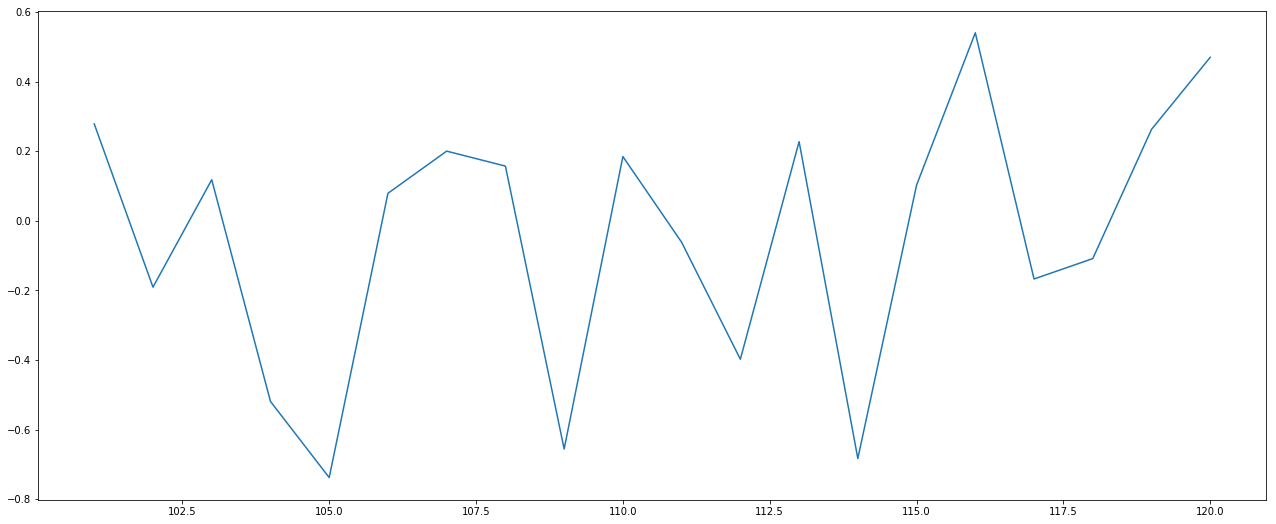

In [50]:
plt.plot(y[100:120])

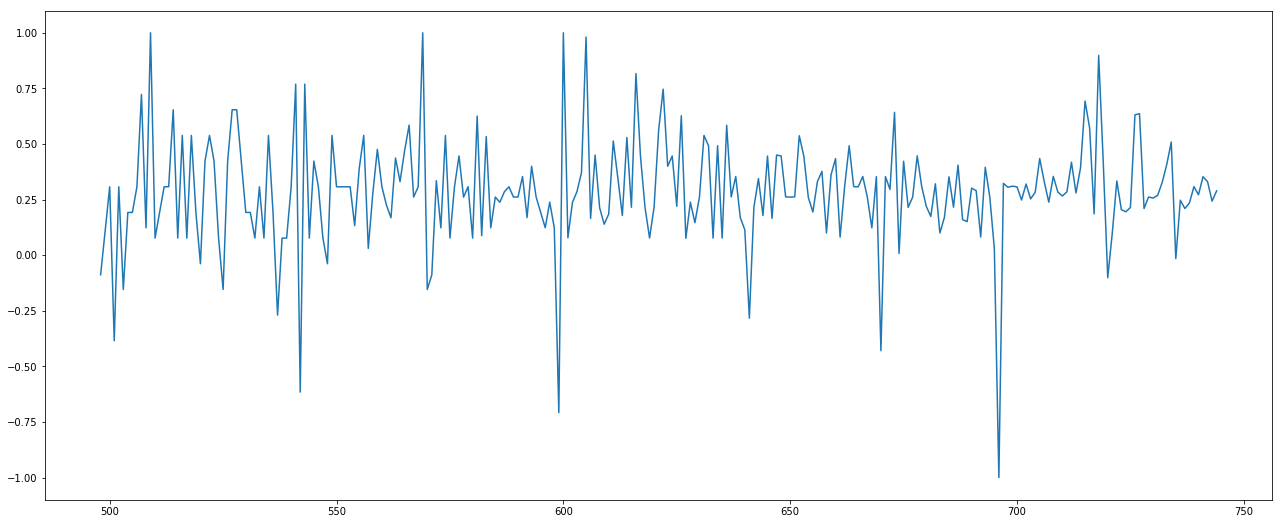

In [51]:
plt.plot(y[482:728]) # the range for TTNP

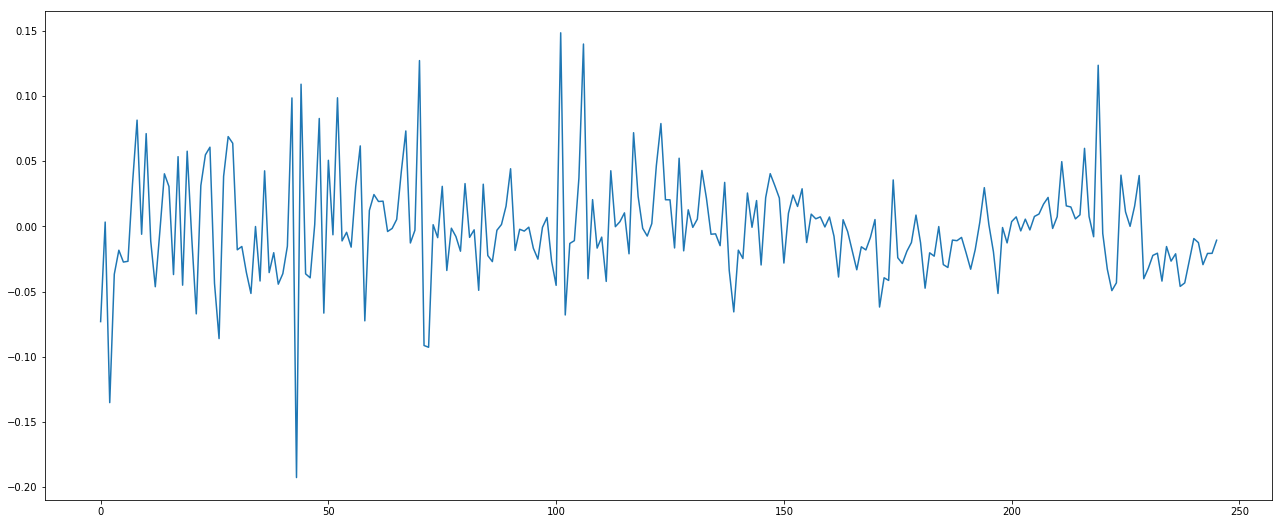

In [52]:
plt.plot(y_scalers['TTNP'].inverse_transform(model.predict(np.reshape(X[482:728], (-1, 1, num_df_cols)))))

In [53]:
def pad_stock(symbol):
    dumdums = np.zeros(len(basket))
    dumdums[list(dummies.columns.values).index(symbol)] = 1.
    return dumdums

In [54]:
pad_stock('TWTR')

array([0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [55]:
model.save('market_model.h5')

In [88]:
#model = tf.keras.models.load_model('market_model.h5')

## Pop off the model head and add a different one that we will finetune per stock

In [91]:
model.layers

In [92]:
model.pop()
model.pop()

In [93]:
# Freeze the 2 older dense layers
model.layers[0].trainable = False
model.layers[3].trainable = False

In [94]:
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1))

In [95]:
basket_dfs = {}
specific_models = {}
for stock in basket:
    basket_dfs[stock] = df[df['symbol'] == stock]
    specific_models[stock] = tf.keras.models.clone_model(model)
    specific_models[stock].set_weights(model.get_weights())

In [96]:
specific_models['EAT'].layers

In [97]:
for stock in basket:
    specific_models[stock].compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [98]:
Xes = {}
ys = {}
for stock in basket:
    repeated_dummies = pad_stock(stock).reshape(1,-1).repeat(len(basket_dfs[stock]),axis=0)
    Xes[stock] = np.append(basket_dfs[stock].drop(['tomo_gain', 'symbol'], axis=1).values, repeated_dummies, axis=1)
    Xes[stock] = np.reshape(Xes[stock], (-1, 1, num_df_cols))
    ys[stock] = basket_dfs[stock]['tomo_gain'].values.reshape(-1,1)

In [99]:
Xes_train, ys_train, Xes_test, ys_test, best_model_scores, best_model = {}, {}, {}, {}, {}, {}

In [106]:
for stock in basket:
    best_model_scores[stock] = 1e6
for stock in basket:
    Xes_train[stock] = Xes[stock][:-5]
    ys_train[stock] = ys[stock][:-5]
    Xes_test[stock] = Xes[stock][-5:]
    ys_test[stock] = ys[stock][-5:]
    for i in range(8):
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=64, epochs=100, verbose=0)
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=16, epochs=30, verbose=0)
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=1, epochs=1, verbose=0)
        evaluation = specific_models[stock].evaluate(Xes_test[stock], ys_test[stock])[0]
        if evaluation < best_model_scores[stock]:
            best_model_scores[stock] = evaluation
            print('now saving {} because it was the best with eval score {}'.format(stock, evaluation))
            best_model[stock] = tf.keras.models.clone_model(specific_models[stock])
            best_model[stock].set_weights(specific_models[stock].get_weights())
            best_model[stock].compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
        else:
            print('did not save {} because it did not improve with eval score {}'.format(stock, evaluation))

5/5 [==============================] - 0s 512us/step
now saving EAT because it was the best with eval score 0.15555354952812195
5/5 [==============================] - 0s 505us/step
did not save EAT because it did not improve with eval score 0.2139556109905243
5/5 [==============================] - 0s 556us/step
did not save EAT because it did not improve with eval score 0.19512569904327393
5/5 [==============================] - 0s 524us/step
did not save EAT because it did not improve with eval score 0.31412529945373535
5/5 [==============================] - 0s 515us/step
did not save EAT because it did not improve with eval score 0.38720813393592834
5/5 [==============================] - 0s 482us/step
did not save EAT because it did not improve with eval score 0.37099429965019226
5/5 [==============================] - 0s 597us/step
did not save EAT because it did not improve with eval score 0.27856922149658203
5/5 [==============================] - 0s 513us/step
did not save EAT becau

5/5 [==============================] - 0s 525us/step
did not save ACB because it did not improve with eval score 0.05521579831838608
5/5 [==============================] - 0s 674us/step
did not save ACB because it did not improve with eval score 0.06965171545743942
5/5 [==============================] - 7s 1s/step
now saving GREK because it was the best with eval score 0.36332258582115173
5/5 [==============================] - 0s 789us/step
now saving GREK because it was the best with eval score 0.30157163739204407
5/5 [==============================] - 0s 917us/step
did not save GREK because it did not improve with eval score 0.6863018274307251
5/5 [==============================] - 0s 566us/step
did not save GREK because it did not improve with eval score 0.33701154589653015
5/5 [==============================] - 0s 591us/step
now saving GREK because it was the best with eval score 0.16809645295143127
5/5 [==============================] - 0s 556us/step
did not save GREK because it d

# Now let's reassign it for simplicity

In [107]:
for stock in basket:
    specific_models[stock] = best_model[stock]

# Sanity checks

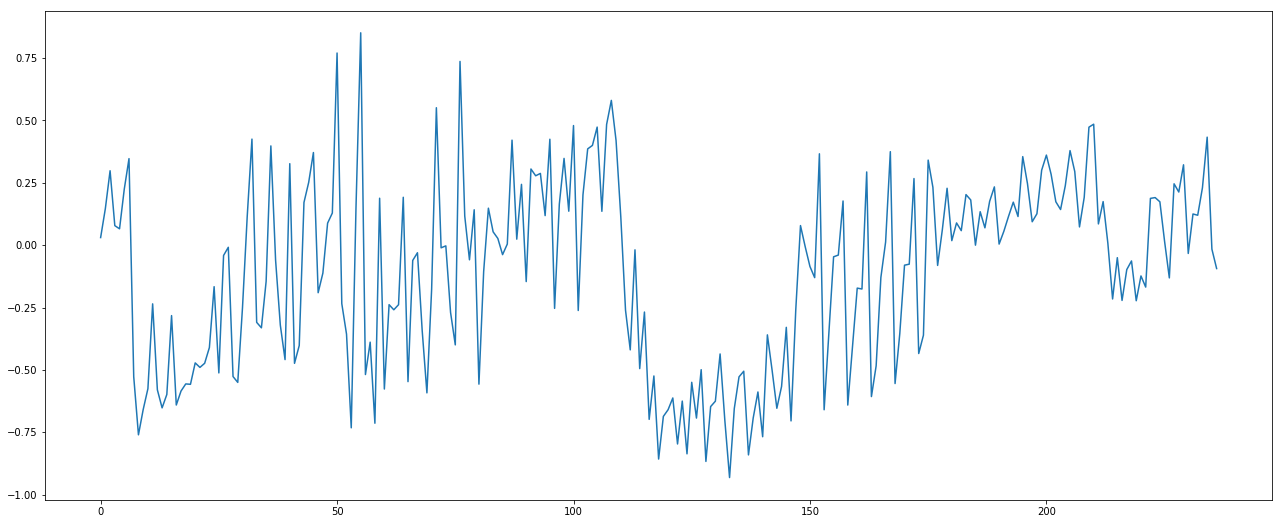

In [108]:
plt.plot(y_scalers['TWTR'].inverse_transform(specific_models['TWTR'].predict(Xes['TWTR'])))

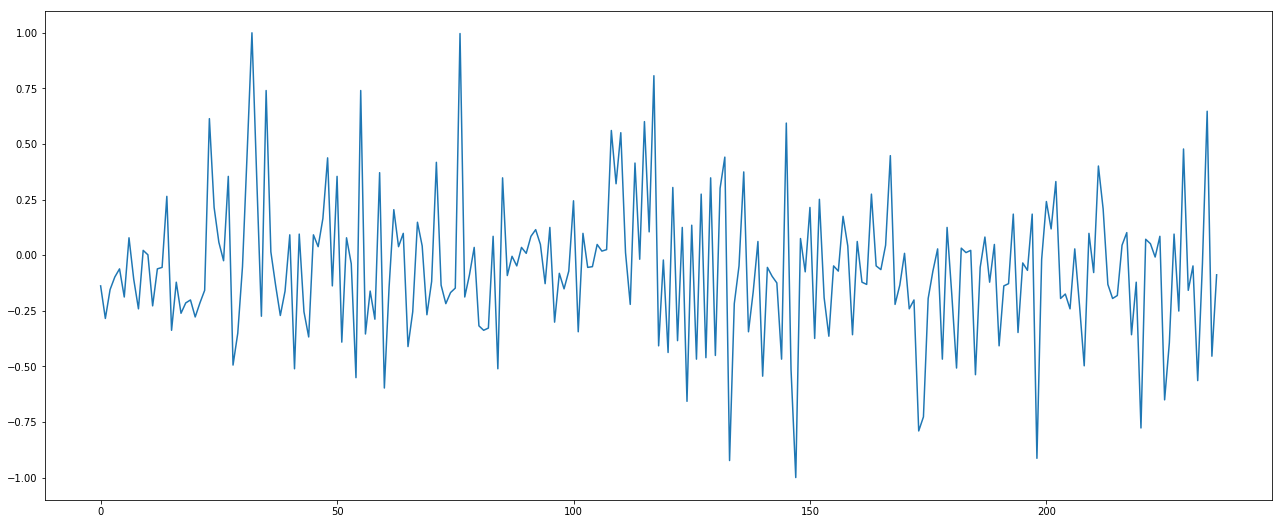

In [109]:
plt.plot(ys['TWTR'])

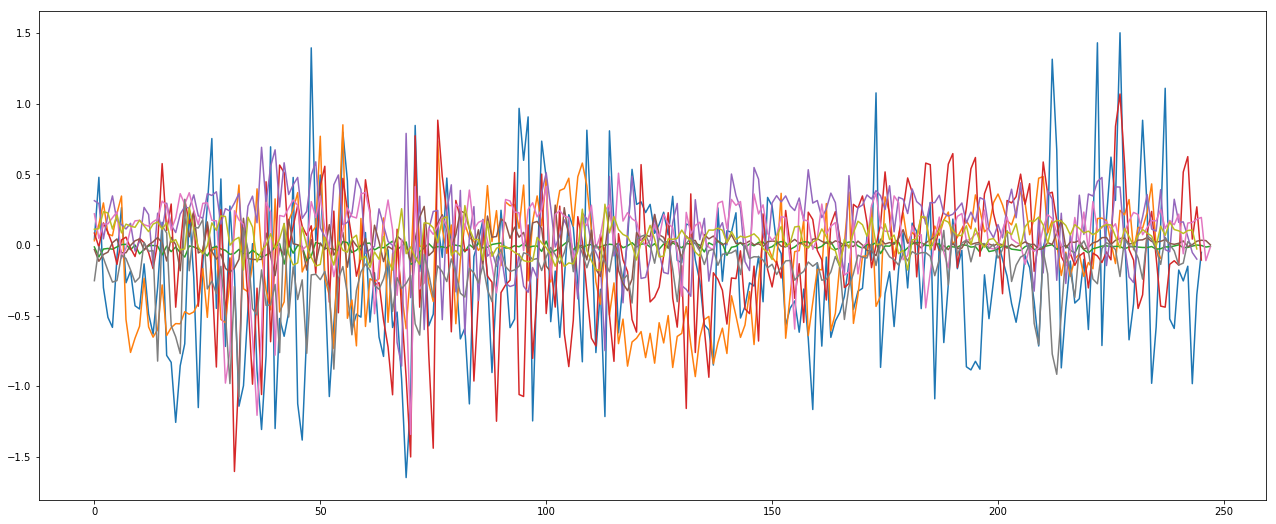

In [110]:
for stock in basket:
    plt.plot(y_scalers[stock].inverse_transform(specific_models[stock].predict(Xes[stock])))

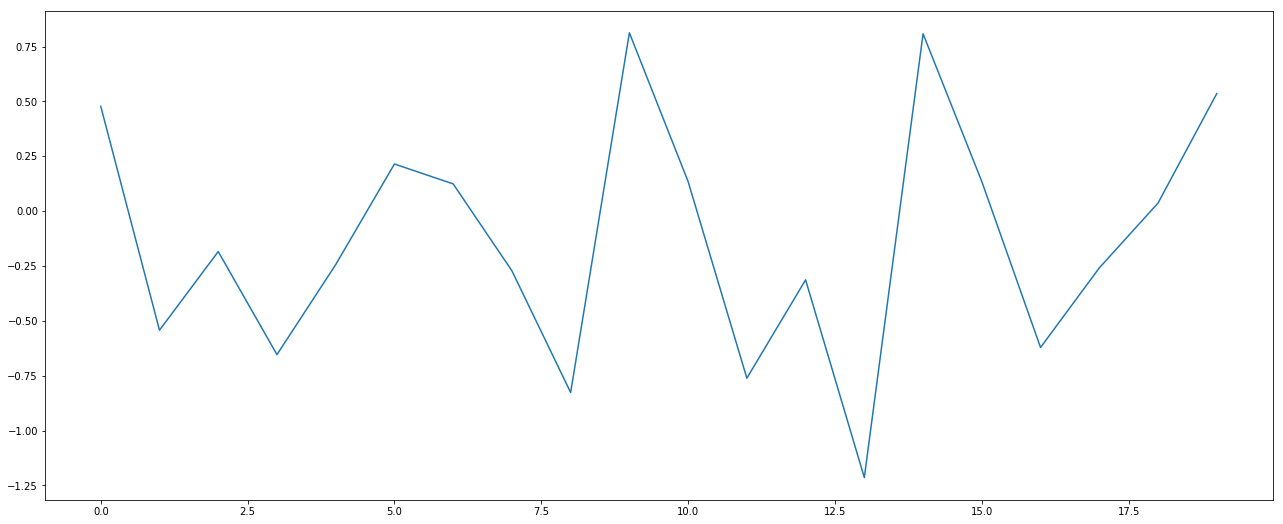

In [111]:
plt.plot(y_scalers['EAT'].inverse_transform(specific_models['EAT'].predict(Xes['EAT'][100:120])))

# Make some predictions for tomorrow

I'm not sure if these have valid units by now, but definitely larger numbers mean higher gains, and v.v. Note that the RNN should be warmed up on a few previous days' data first; one-off predictions will not be as good so don't use it like this (see below instead).

In [114]:
for stock in basket:
    today = df[df['symbol'] == stock].iloc[-1].drop(['tomo_gain', 'symbol'])
    today = np.append(today, pad_stock(stock))
    specific_models[stock].reset_states()
    pred = specific_models[stock].predict(np.reshape(today, (-1, 1, num_df_cols)))
    pred = y_scalers[stock].inverse_transform(pred)
    print("Stock {}, pred: {}".format(stock, np.asscalar(pred)))

Stock EAT, pred: -0.05196968466043472
Stock TWTR, pred: -0.09361664950847626
Stock TTNP, pred: -0.008990226313471794
Stock SBUX, pred: -0.10612526535987854
Stock BAC, pred: -0.0994410440325737
Stock SHLDQ, pred: 0.00150995550211519
Stock STM, pred: -0.013806299306452274
Stock ACB, pred: -0.0026745768263936043
Stock GREK, pred: -0.027660313993692398


# Save the fine tuned models

In [115]:
for stock, model in specific_models.items():
    model.save('finetuned_{}.h5'.format(stock))

# With the models built, run this to generate new predictions for the most recent day

In [116]:
X_scalers = pickle.load(open('x_scalers.pkl', 'rb'))
y_scalers = pickle.load(open('y_scalers.pkl', 'rb'))

In [117]:
specific_models = {}
for stock in basket:
    specific_models[stock] = tf.keras.models.load_model('finetuned_{}.h5'.format(stock))

In [118]:
new_day = data.DataReader(basket, 'robinhood')

In [119]:
new_day.tail()

close_price high_price  interpolated low_price open_price  \
symbol begins_at                                                              
GREK   2018-11-29    7.370000   7.420000         False  7.300000   7.300000   
       2018-11-30    7.510000   7.530000         False  7.380000   7.390000   
       2018-12-03    7.910000   7.930000         False  7.710000   7.770000   
       2018-12-04    7.680000   7.890000         False  7.660000   7.890000   
       2018-12-05    7.680000   7.680000          True  7.680000   7.680000   

                  session  volume  
symbol begins_at                   
GREK   2018-11-29     reg  269125  
       2018-11-30     reg  629851  
       2018-12-03     reg  455622  
       2018-12-04     reg  244417  
       2018-12-05     reg       0

In [120]:
new_day = new_day.reset_index()

In [121]:
for stock in basket:
    for col in ('close_price', 'high_price', 'low_price', 'open_price', 'volume'):
        new_day[col] = new_day[col].astype(float)
        new_day.loc[new_day['symbol'] == stock, col] = signal.detrend(new_day[new_day['symbol'] == stock][col])
    new_day.loc[new_day['symbol'] == stock, 'mean_close_price_2'] = new_day.loc[new_day['symbol'] == stock, 'close_price'].rolling(window=2).mean()
    new_day.loc[new_day['symbol'] == stock, 'mean_close_price_3'] = new_day.loc[new_day['symbol'] == stock, 'close_price'].rolling(window=3).mean()
    new_day.loc[new_day['symbol'] == stock, 'std_close_price_2'] = new_day.loc[new_day['symbol'] == stock, 'close_price'].rolling(window=2).std()
    new_day.loc[new_day['symbol'] == stock, 'std_close_price_3'] = new_day.loc[new_day['symbol'] == stock, 'close_price'].rolling(window=3).std()

In [122]:
new_day['tomo_gain'] = new_day['close_price'].shift(-1) - new_day['close_price']
new_day['yday_gain'] = new_day['tomo_gain'].shift(1)

In [123]:
as_date = new_day['begins_at'].dt
new_day['dayofweek'] = as_date.dayofweek
new_day['quarter'] = as_date.quarter
new_day['weekofyear'] = as_date.weekofyear
new_day = new_day.drop(['begins_at', 'interpolated', 'session'], axis=1)
new_day = new_day.dropna(axis=0)
new_day = new_day.reset_index(drop=True)
for stock in basket:
    new_day = new_day.drop(new_day.index[len(new_day[new_day['symbol'] == stock]) - 1], axis=0)
    outliers = abs(new_day[new_day['symbol'] == stock]['tomo_gain']) < new_day[new_day['symbol'] == stock]['tomo_gain'].std() * 3
    new_day[new_day['symbol'] == stock] = new_day[new_day['symbol'] == stock].loc[:, :][outliers]
    new_day = new_day.drop(new_day[new_day['symbol'] == stock].iloc[-1].name)
    for col in ('close_price', 'high_price', 'low_price', 'open_price', 'volume', 'mean_close_price_2', \
               'mean_close_price_3', 'std_close_price_2', 'std_close_price_3', 'yday_gain'):
        pre_x = new_day[new_day['symbol'] == stock][col]
        new_day.loc[new_day['symbol'] == stock, col] = X_scalers[stock][col].transform(pre_x.values.reshape(-1,1))

In [124]:
new_day = new_day.dropna(axis=0)

In [125]:
dummies = pd.get_dummies(new_day['symbol'], columns=['symbol'])
num_df_cols = new_day.shape[1] - 1 + len(basket) - 1
def pad_stock(symbol):
    dumdums = np.zeros(len(basket))
    dumdums[list(dummies.columns.values).index(symbol)] = 1.
    return dumdums

# Today: This should be better

In [139]:
for stock in basket:
    today = new_day[new_day['symbol'] == stock].iloc[-8:-1].drop(['tomo_gain', 'symbol'], axis=1)
    today = np.append(today, pad_stock(stock).reshape(-1,9).repeat(7,axis=0))
    specific_models[stock].reset_states()
    pred = specific_models[stock].predict(np.reshape(today, (-1, 1, num_df_cols)))
    pred = y_scalers[stock].inverse_transform(pred)
    print("Stock {}, pred: {}".format(stock, np.asscalar(pred[-1])))

Stock EAT, pred: -0.4486190378665924
Stock TWTR, pred: -0.10443814098834991
Stock TTNP, pred: -0.03750665858387947
Stock SBUX, pred: -0.1322951316833496
Stock BAC, pred: -0.0426788367331028
Stock SHLDQ, pred: 0.06239622086286545
Stock STM, pred: -0.18434059619903564
Stock ACB, pred: -0.556468665599823
Stock GREK, pred: 0.11855080723762512
